### Environment & Data Setup

In [3]:
import pandas as pd
import os

base_dir = "/kaggle/input/vindr-spiner/vindr-spinexr-a-large-annotated-medical-image-dataset-for-spinal-lesions-detection-and-classification-from-radiographs-1.0.0"
anno_path = os.path.join(base_dir, "annotations/train.csv")

df_annotations = pd.read_csv(anno_path)
print("Annotations shape:", df_annotations.shape)
df_annotations.head()

Annotations shape: (19550, 9)


,study_id,series_id,image_id,rad_id,lesion_type,xmin,ymin,xmax,ymax
0,88ec4a2f0842407e5489b53728a1709b,c0b663cf5497398f49dd717b46debf06,1f1c5c098c35b79052596aae08ac727f,rad1,Osteophytes,712.636842,961.361404,786.587719,1011.782456
1,88ec4a2f0842407e5489b53728a1709b,c0b663cf5497398f49dd717b46debf06,1f1c5c098c35b79052596aae08ac727f,rad1,Osteophytes,789.949123,1452.126316,880.707018,1505.908772
2,88ec4a2f0842407e5489b53728a1709b,c0b663cf5497398f49dd717b46debf06,1f1c5c098c35b79052596aae08ac727f,rad1,Osteophytes,692.468421,655.473684,746.250877,709.256140
3,88ec4a2f0842407e5489b53728a1709b,c0b663cf5497398f49dd717b46debf06,1f1c5c098c35b79052596aae08ac727f,rad1,Osteophytes,820.201754,1603.389474,910.959649,1670.617544
4,88ec4a2f0842407e5489b53728a1709b,c0b663cf5497398f49dd717b46debf06,1f1c5c098c35b79052596aae08ac727f,rad1,Osteophytes,739.528070,1203.382456,820.201754,1240.357895


### Analyze Distributions (The "Normal" vs "Abnormal" Balance)

In [5]:
# Count unique images and studies
num_images = df_annotations['image_id'].nunique()
num_studies = df_annotations['study_id'].nunique()
print(f"Total Images: {num_images}")
print(f"Total Studies: {num_studies}")

# Check Class Balance (Normal vs Abnormal)
df_unique_images = df_annotations.drop_duplicates(subset=['image_id'])

# FIX: Use 'lesion_type' instead of 'class_name'
normal_count = df_unique_images[df_unique_images['lesion_type'] == 'No finding'].shape[0]
abnormal_count = num_images - normal_count

print(f"Normal Images: {normal_count}")
print(f"Abnormal Images: {abnormal_count}")

Total Images: 8389
Total Studies: 4000
Normal Images: 4260
Abnormal Images: 4129


✅ Loaded annotations from: /kaggle/input/vindr-spiner/vindr-spinexr-a-large-annotated-medical-image-dataset-for-spinal-lesions-detection-and-classification-from-radiographs-1.0.0/annotations/train.csv
Normal ID: 632cb024ade0c499955ef8be91e3f8f4
Abnormal ID: 1f1c5c098c35b79052596aae08ac727f (Osteophytes)


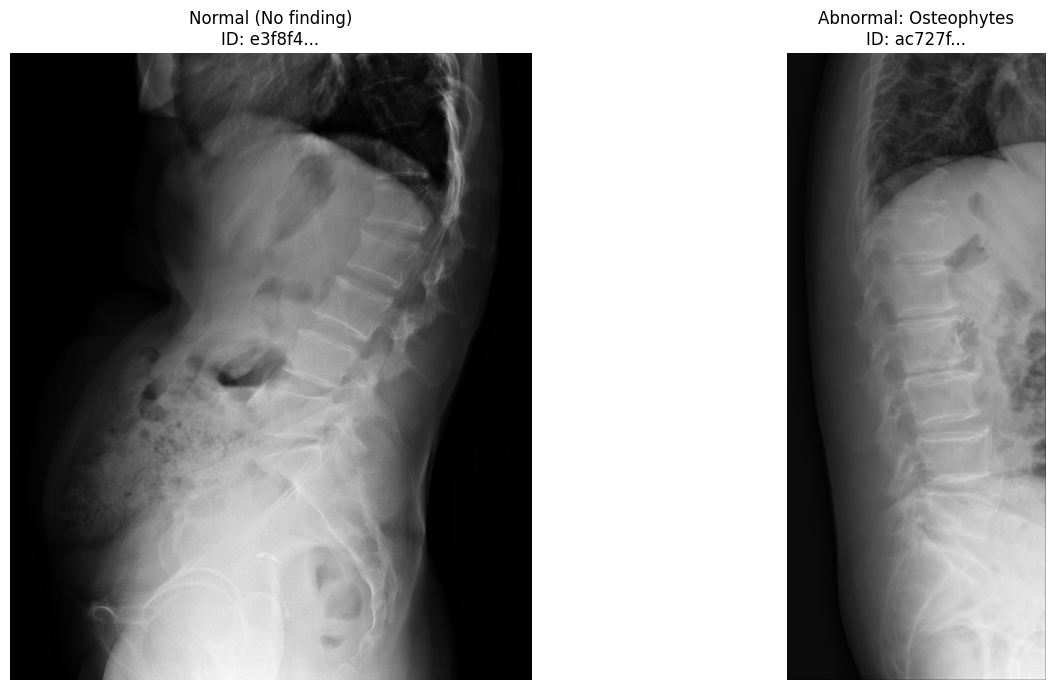

In [6]:
import pandas as pd
import pydicom
import matplotlib.pyplot as plt
import os
import glob
import numpy as np

# 1. Setup Paths
# Adjust this based on your exact folder structure if needed
train_images_dir = os.path.join(base_dir, "train_images")

# Automatically find the train.csv file
search_path = os.path.join(base_dir, "annotations", "*")
found_files = glob.glob(search_path)
anno_path = None

for f in found_files:
    if "train" in f and (f.endswith(".csv") or f.endswith(".json")):
        anno_path = f
        break

if not anno_path and found_files:
    anno_path = found_files[0] # Fallback

if anno_path:
    print(f"✅ Loaded annotations from: {anno_path}")
    df_annotations = pd.read_csv(anno_path)
    
    # 2. Select Image IDs
    # Normal: 'lesion_type' is 'No finding'
    normal_sample = df_annotations[df_annotations['lesion_type'] == 'No finding'].iloc[0]
    normal_id = normal_sample['image_id']
    
    # Abnormal: 'lesion_type' is NOT 'No finding'
    abnormal_sample = df_annotations[df_annotations['lesion_type'] != 'No finding'].iloc[0]
    abnormal_id = abnormal_sample['image_id']
    abnormal_label = abnormal_sample['lesion_type']

    print(f"Normal ID: {normal_id}")
    print(f"Abnormal ID: {abnormal_id} ({abnormal_label})")

    # 3. Define Plotting Function
    def read_and_plot_dicom(ax, image_id, label_title):
        # Handle potential file extensions
        dicom_path = os.path.join(train_images_dir, f"{image_id}.dicom")
        if not os.path.exists(dicom_path):
            dicom_path = os.path.join(train_images_dir, f"{image_id}.dcm")
            
        if os.path.exists(dicom_path):
            ds = pydicom.dcmread(dicom_path)
            pixel_array = ds.pixel_array
            
            # Fix Monochrome Inversion if necessary
            if hasattr(ds, "PhotometricInterpretation") and ds.PhotometricInterpretation == "MONOCHROME1":
                pixel_array = np.amax(pixel_array) - pixel_array
            
            # Normalize for better visualization
            pixel_array = pixel_array - np.min(pixel_array)
            if np.max(pixel_array) != 0:
                pixel_array = pixel_array / np.max(pixel_array)
            
            ax.imshow(pixel_array, cmap='gray')
            ax.set_title(f"{label_title}\nID: {image_id[-6:]}...")
            ax.axis('off')
        else:
            ax.text(0.5, 0.5, "Image Not Found", ha='center')
            print(f"❌ File not found: {dicom_path}")

    # 4. Display Images
    fig, axes = plt.subplots(1, 2, figsize=(15, 7))
    
    # Plot Normal
    read_and_plot_dicom(axes[0], normal_id, "Normal (No finding)")
    
    # Plot Abnormal
    read_and_plot_dicom(axes[1], abnormal_id, f"Abnormal: {abnormal_label}")
    
    plt.tight_layout()
    plt.show()

else:
    print("❌ Could not find annotation file.")

### Analyze Lesion Types

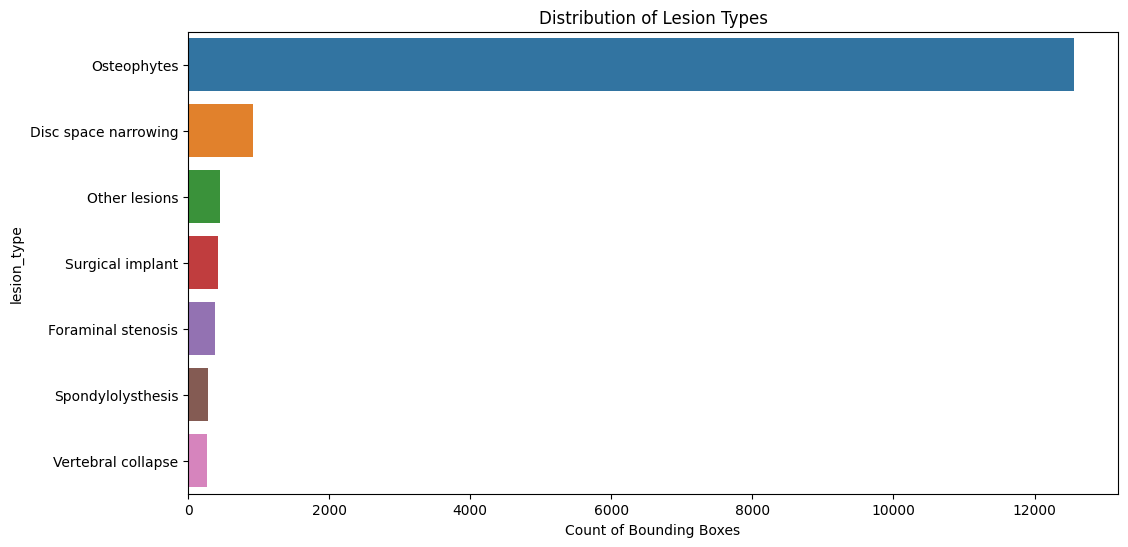

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# FIX: Use 'lesion_type'
lesions = df_annotations[df_annotations['lesion_type'] != 'No finding']

plt.figure(figsize=(12, 6))
sns.countplot(y='lesion_type', data=lesions, order=lesions['lesion_type'].value_counts().index)
plt.title("Distribution of Lesion Types")
plt.xlabel("Count of Bounding Boxes")
plt.show()

✅ Annotations: /kaggle/input/vindr-spiner/vindr-spinexr-a-large-annotated-medical-image-dataset-for-spinal-lesions-detection-and-classification-from-radiographs-1.0.0/annotations/train.csv
Found 8 unique lesion types.


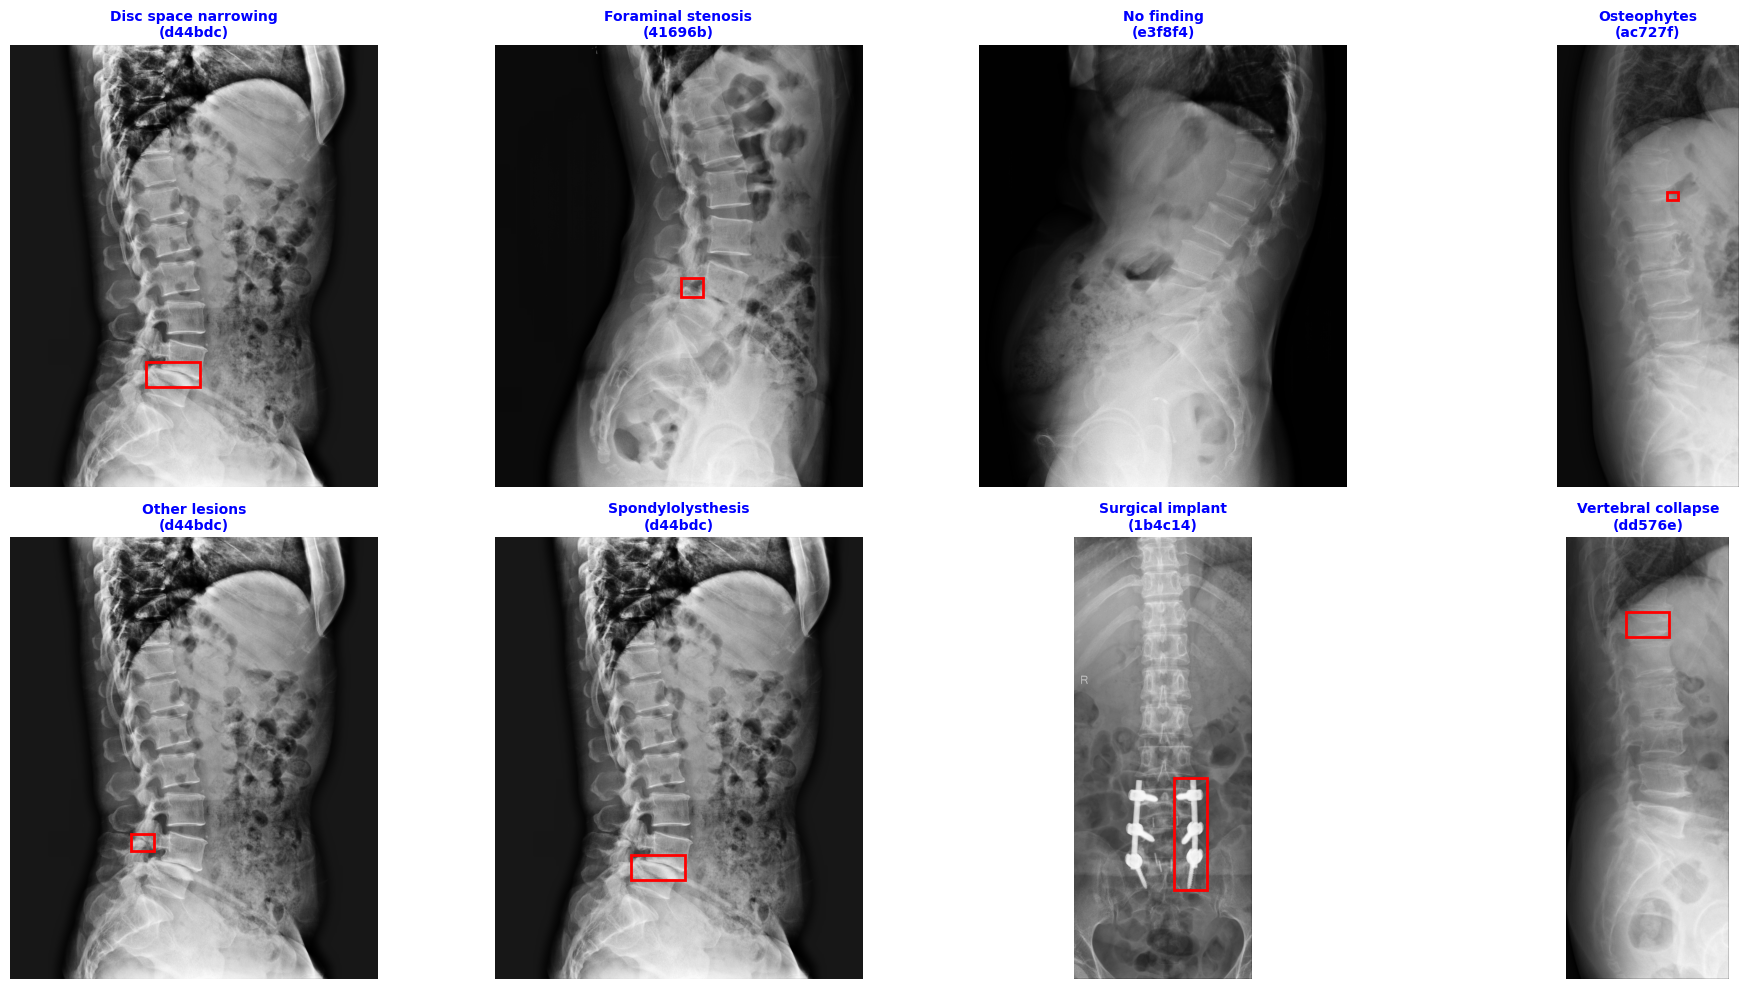

In [8]:
import pandas as pd
import pydicom
import matplotlib.pyplot as plt
import os
import glob
import numpy as np
import math

# 1. Setup Paths
train_images_dir = os.path.join(base_dir, "train_images")

# Auto-locate annotations
search_path = os.path.join(base_dir, "annotations", "*")
found_files = glob.glob(search_path)
anno_path = None
for f in found_files:
    if "train" in f and (f.endswith(".csv") or f.endswith(".json")):
        anno_path = f
        break
if not anno_path and found_files: anno_path = found_files[0]

if anno_path:
    print(f"✅ Annotations: {anno_path}")
    df = pd.read_csv(anno_path)
    
    # 2. Get Unique Lesion Types
    lesion_types = df['lesion_type'].unique()
    print(f"Found {len(lesion_types)} unique lesion types.")
    
    # 3. Setup Grid Plot
    num_lesions = len(lesion_types)
    cols = 4
    rows = math.ceil(num_lesions / cols)
    
    fig, axes = plt.subplots(rows, cols, figsize=(20, 5 * rows))
    axes = axes.flatten()
    
    # 4. Iterate and Plot
    for i, lesion in enumerate(sorted(lesion_types)):
        # Get a sample image ID for this lesion
        sample_row = df[df['lesion_type'] == lesion].iloc[0]
        image_id = sample_row['image_id']
        
        # Construct Path (Handle variations)
        dicom_path = os.path.join(train_images_dir, f"{image_id}.dicom")
        if not os.path.exists(dicom_path):
            dicom_path = os.path.join(train_images_dir, f"{image_id}.dcm")
            
        ax = axes[i]
        
        if os.path.exists(dicom_path):
            try:
                ds = pydicom.dcmread(dicom_path)
                pixel_array = ds.pixel_array
                
                # Fix Monochrome
                if hasattr(ds, "PhotometricInterpretation") and ds.PhotometricInterpretation == "MONOCHROME1":
                    pixel_array = np.amax(pixel_array) - pixel_array
                
                # Normalize for display
                pixel_array = pixel_array - np.min(pixel_array)
                if np.max(pixel_array) != 0:
                    pixel_array = pixel_array / np.max(pixel_array)
                
                ax.imshow(pixel_array, cmap='gray')
                
                # Draw Box if present
                if lesion != 'No finding':
                    # Assuming CSV format: xmin, ymin, xmax, ymax
                    # Check your actual column names from previous cell output
                    if 'xmin' in sample_row:
                        x = sample_row['xmin']
                        y = sample_row['ymin']
                        w = sample_row['xmax'] - sample_row['xmin']
                        h = sample_row['ymax'] - sample_row['ymin']
                        rect = plt.Rectangle((x, y), w, h, linewidth=2, edgecolor='red', facecolor='none')
                        ax.add_patch(rect)
                        
                ax.set_title(f"{lesion}\n({image_id[-6:]})", fontsize=10, color='blue', weight='bold')
            except Exception as e:
                ax.text(0.5, 0.5, f"Error reading\n{image_id}", ha='center')
        else:
            ax.text(0.5, 0.5, "File Not Found", ha='center')
            
        ax.axis('off')
        
    # Turn off unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
        
    plt.tight_layout()
    plt.show()
    
else:
    print("❌ Annotation file not found.")

### Visualize Bounding Boxes

✅ Loaded annotations: /kaggle/input/vindr-spiner/vindr-spinexr-a-large-annotated-medical-image-dataset-for-spinal-lesions-detection-and-classification-from-radiographs-1.0.0/annotations/train.csv
Found 8 unique lesion types.


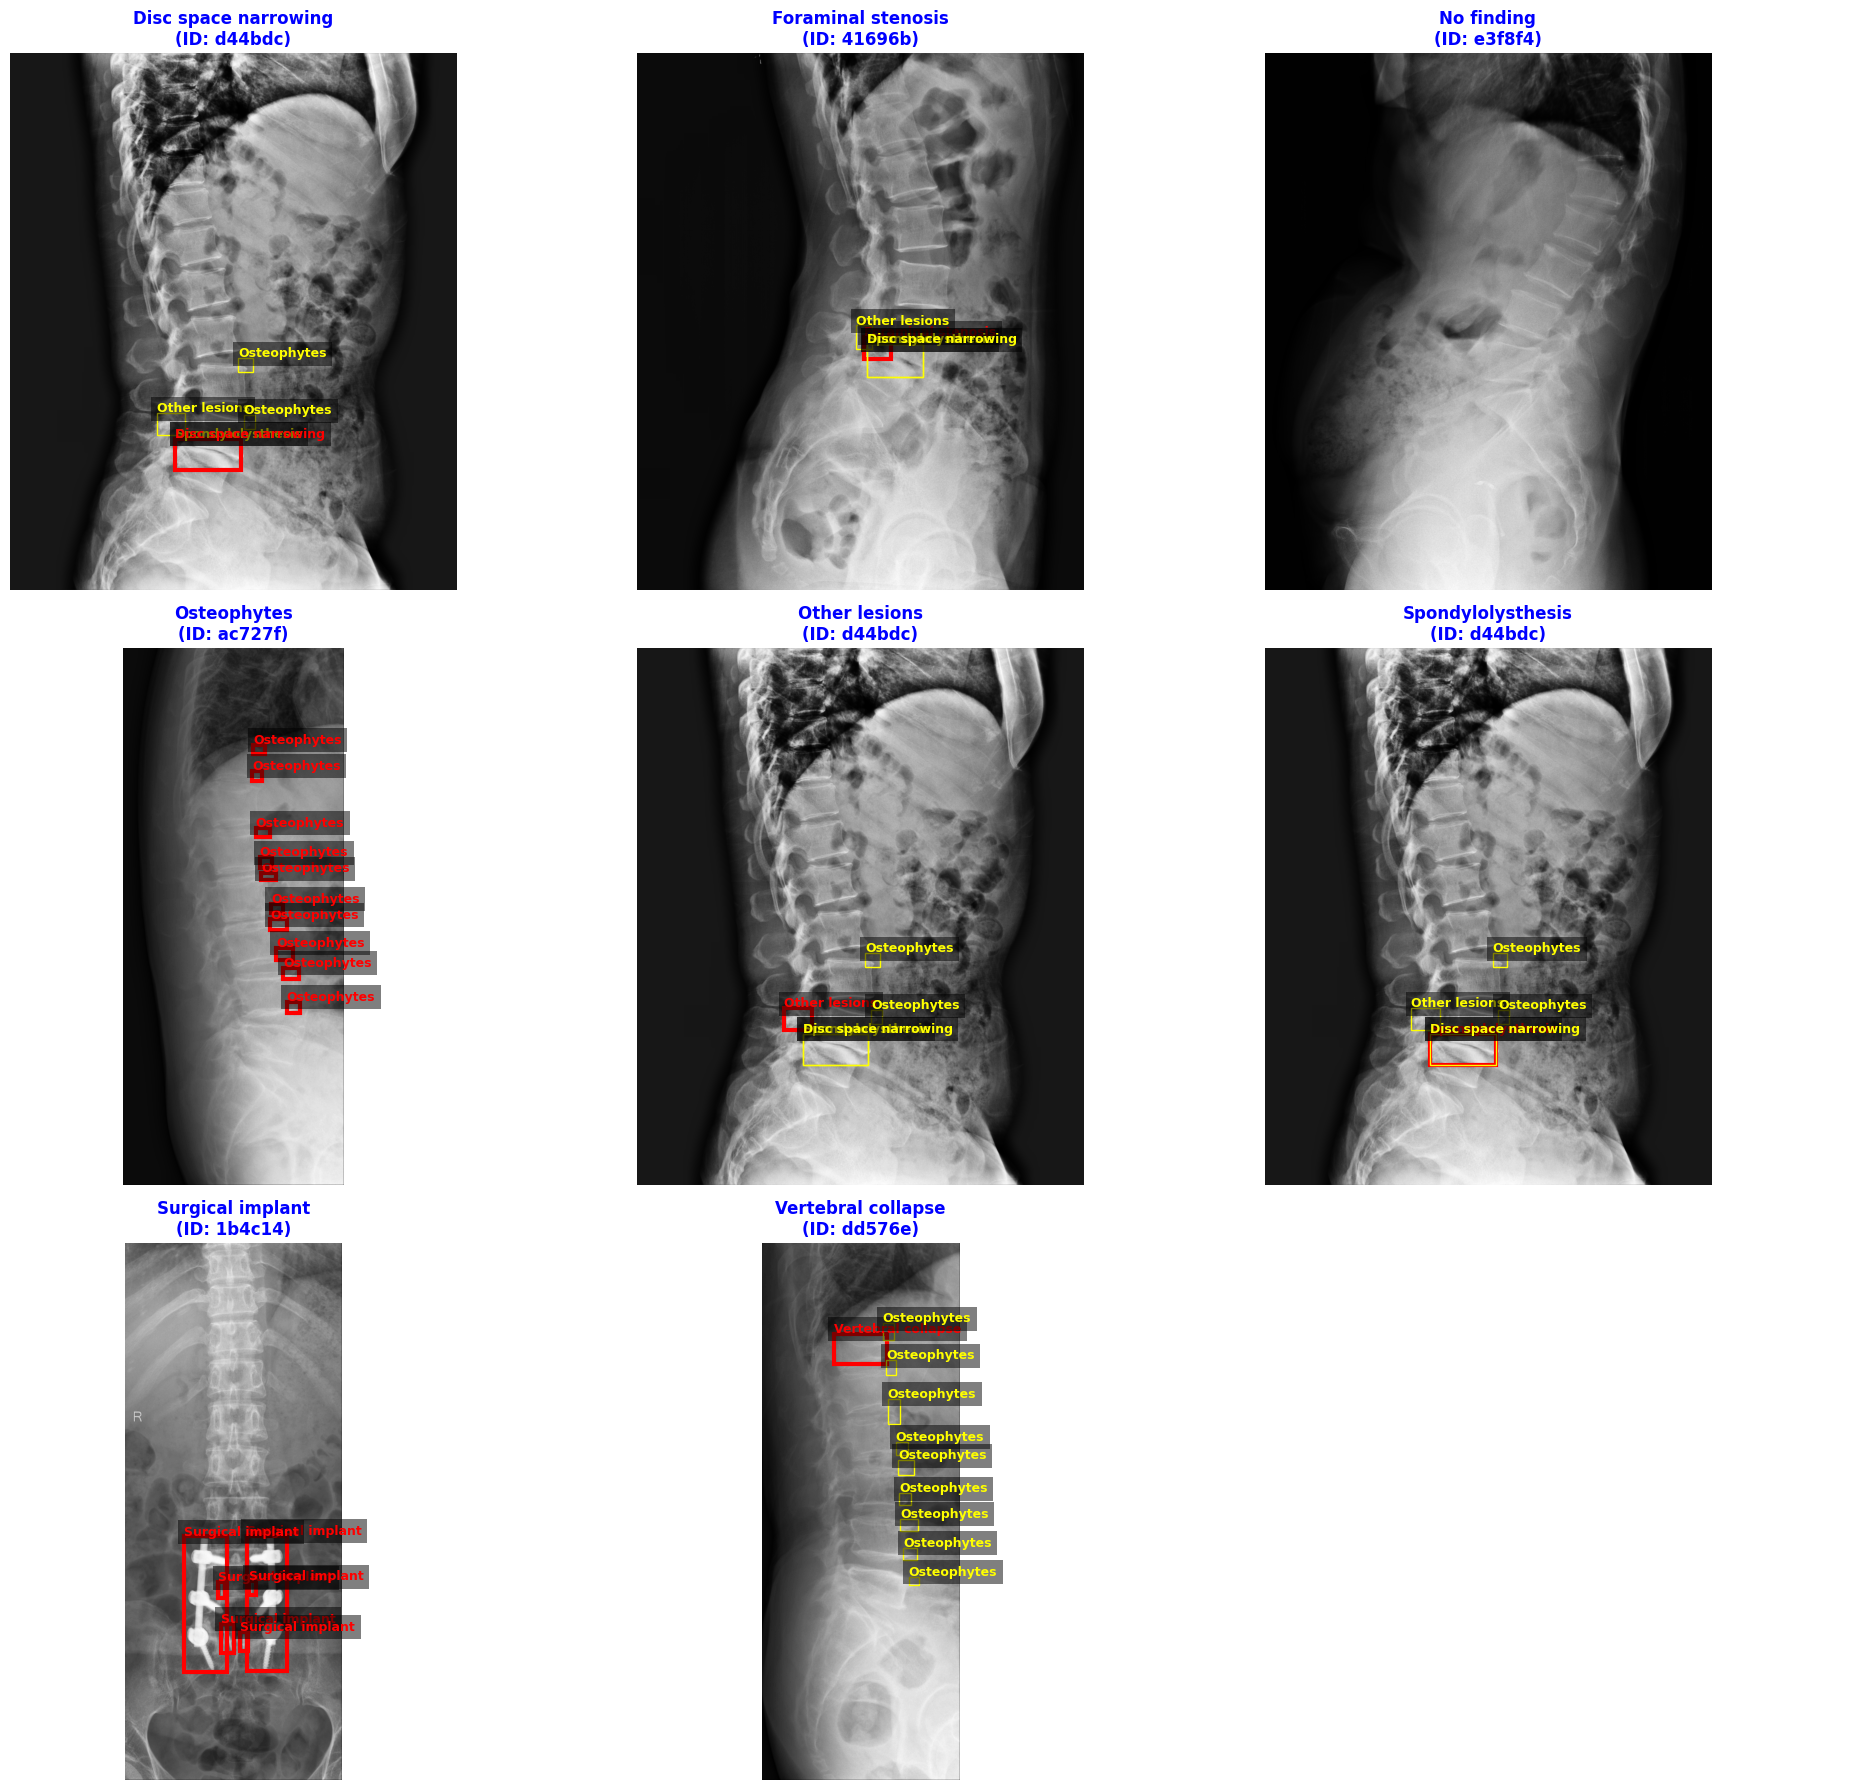

In [10]:
import pandas as pd
import pydicom
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import glob
import math
import numpy as np

# --- 1. Setup Paths & Load Data ---
train_images_dir = os.path.join(base_dir, "train_images")

# Auto-find annotations
search_path = os.path.join(base_dir, "annotations", "*")
found_files = glob.glob(search_path)
anno_path = next((f for f in found_files if "train" in f and (f.endswith(".csv") or f.endswith(".json"))), found_files[0] if found_files else None)

if not anno_path:
    raise FileNotFoundError("Annotation file not found!")

print(f"✅ Loaded annotations: {anno_path}")
df = pd.read_csv(anno_path)

# --- 2. Identify All Unique Lesion Types ---
# Get all unique types, sort them alphabetically
lesion_types = sorted(df['lesion_type'].unique())
print(f"Found {len(lesion_types)} unique lesion types.")

# --- 3. Setup Grid Visualization ---
cols = 3
rows = math.ceil(len(lesion_types) / cols)
fig, axes = plt.subplots(rows, cols, figsize=(20, 6 * rows))
axes = axes.flatten()

# --- 4. Iterate Through Each Lesion Type ---
for i, lesion in enumerate(lesion_types):
    ax = axes[i]
    
    # Pick the first image that contains this specific lesion
    sample_row = df[df['lesion_type'] == lesion].iloc[0]
    image_id = sample_row['image_id']
    
    # Find the DICOM file
    dicom_path = os.path.join(train_images_dir, f"{image_id}.dicom")
    if not os.path.exists(dicom_path):
        dicom_path = os.path.join(train_images_dir, f"{image_id}.dcm")
    
    if os.path.exists(dicom_path):
        # Load DICOM
        ds = pydicom.dcmread(dicom_path)
        pixel_array = ds.pixel_array
        
        # Monochrome Fix
        if hasattr(ds, "PhotometricInterpretation") and ds.PhotometricInterpretation == "MONOCHROME1":
            pixel_array = np.amax(pixel_array) - pixel_array
            
        # Normalize
        pixel_array = pixel_array - np.min(pixel_array)
        if np.max(pixel_array) != 0:
            pixel_array = pixel_array / np.max(pixel_array)
            
        ax.imshow(pixel_array, cmap='gray')
        ax.set_title(f"{lesion}\n(ID: {image_id[-6:]})", color='blue', fontsize=12, weight='bold')
        
        # --- Draw Bounding Boxes ---
        # Get ALL annotations for this specific image (it might have multiple lesions)
        img_annos = df[df['image_id'] == image_id]
        
        if lesion != 'No finding':
            for _, row in img_annos.iterrows():
                # Draw box only if coordinates exist
                if 'xmin' in row and 'ymin' in row:
                    x, y = row['xmin'], row['ymin']
                    w = row['xmax'] - row['xmin']
                    h = row['ymax'] - row['ymin']
                    
                    # Highlight the CURRENT lesion type in RED, others in YELLOW
                    color = 'red' if row['lesion_type'] == lesion else 'yellow'
                    linewidth = 3 if row['lesion_type'] == lesion else 1
                    
                    rect = patches.Rectangle((x, y), w, h, linewidth=linewidth, edgecolor=color, facecolor='none')
                    ax.add_patch(rect)
                    
                    # Add label text
                    ax.text(x, y - 5, row['lesion_type'], color=color, fontsize=9, weight='bold', 
                            bbox=dict(facecolor='black', alpha=0.5, edgecolor='none'))
    else:
        ax.text(0.5, 0.5, "Image Not Found", ha='center')
        
    ax.axis('off')

# Turn off empty subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()